# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_006  Q9UKZ4;Q9UKZ4-2            12.518
Sample_161  O60476                     15.874
Sample_066  P10745                     15.020
Sample_120  G3XAI2;P07942              16.572
Sample_074  Q99674;Q99674-4;Q99674-5   16.975
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                       
Sample_042  J3QQR8;J3QQX6;J3QRQ1;J3QRT5;P13598      15.531
Sample_186  A0A087WTT8;A0A0A0MQX5;O94779;O94779-2   13.312
Sample_184  B1AJQ6;Q86Y82                           15.658
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.556
            A0A075B6Q5                 13.226
            A0A075B6R2                 12.341
            A0A075B6S5                 13.348
            A0A087WSY4                 12.559
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.546
            Q9UI40;Q9UI40-2            12.266
            Q9UIW2                     13.590
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.519
            Q9UP79                     12.891
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.000,15.050,16.842,19.863,16.088,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.689,19.067,...,15.528,15.576,14.141,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.802,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.813,17.705,17.039,15.598,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.930,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.652,15.345,17.084,18.708,14.249,19.433,11.840,10.960
Sample_207,15.739,16.877,15.469,16.898,13.202,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.556,...,16.012,15.178,12.307,15.050,16.842,19.863,13.936,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.876,19.067,16.188,...,15.528,15.576,13.034,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.500,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.523,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.430,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.269,15.345,17.084,18.708,14.249,19.433,13.809,13.436
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 402.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.91it/s]

100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.63it/s]

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.95it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.33it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.62it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.47it/s]

100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.77it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.44it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.20it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.09it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.65it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.19it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.01it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.93it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.93it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.71it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.92it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.48it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.20it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.06it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.01it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.00it/s]

100%|██████████| 9/9 [00:02<00:00,  2.92it/s]

100%|██████████| 9/9 [00:02<00:00,  3.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.17it/s]

 30%|███       | 3/10 [00:00<00:01,  3.56it/s]

 40%|████      | 4/10 [00:01<00:01,  3.29it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.11it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.05it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.69it/s]

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.01it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.47it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.13it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.03it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.02it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.92it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.89it/s]

100%|██████████| 11/11 [00:05<00:00,  1.76it/s]

100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.74it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.96it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.80it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.88it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.82it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.80it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.77it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.58it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.67it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.54it/s]

 31%|███       | 4/13 [00:01<00:02,  3.10it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.63it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.32it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.04it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.99it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.16it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.16it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.93it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.91it/s]

100%|██████████| 13/13 [00:05<00:00,  1.89it/s]

100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.26it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.59it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.22it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.12it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.94it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.83it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.85it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.86it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.60it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.22it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.05it/s]

100%|██████████| 14/14 [00:05<00:00,  2.23it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.72it/s]

 20%|██        | 3/15 [00:00<00:02,  4.01it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.51it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.40it/s]

 40%|████      | 6/15 [00:01<00:02,  3.18it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.66it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.33it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.12it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  1.98it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.85it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.80it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.76it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.88it/s]

100%|██████████| 15/15 [00:06<00:00,  1.91it/s]

100%|██████████| 15/15 [00:06<00:00,  2.25it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.008 0.006      0.096 0.036          0.724 0.383       0.100   
2             0.006 0.005      0.076 0.024          0.723 0.100       0.557   
3             0.005 0.003      0.058 0.019          0.772 0.109       0.711   
4             0.005 0.004      0.060 0.020          0.767 0.098       0.730   
5             0.005 0.003      0.063 0.021          0.813 0.090       0.744   
6             0.005 0.004      0.070 0.025          0.817 0.093       0.774   
7             0.004 0.002      0.058 0.018          0.817 0.094       0.779   
8             0.005 0.004      0.072 0.026          0.812 0.093       0.782   
9             0.005 0.004      0.063 0.024          0.822 0.088       0.845   
10            0.006 0.005      0.063 0.023          0.820 0.086       0.835   
11            0.006 0.004      0.064 0.025          0.825 0.079       0.821   
12            0.006 0.005      0.076 0.031          0.822 0.079       0.822   
13            0.005 0.005      0.064 0.027          0.815 0.080       0.811   
14            0.006 0.004      0.079 0.032          0.810 0.083       0.805   
15            0.006 0.005      0.059 0.018          0.809 0.079       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.169 0.122                  0.543 0.038        0.861   
2          0.116   0.622 0.091                  0.698 0.063        0.798   
3          0.118   0.733 0.086                  0.775 0.069        0.873   
4          0.119   0.742 0.084                  0.781 0.067        0.883   
5          0.100   0.772 0.074                  0.807 0.061        0.902   
6          0.092   0.791 0.072                  0.822 0.060        0.910   
7          0.090   0.793 0.072                  0.823 0.060        0.908   
8          0.096   0.792 0.073                  0.823 0.062        0.908   
9          0.099   0.828 0.069                  0.853 0.061        0.921   
10         0.100   0.823 0.070                  0.849 0.061        0.919   
11         0.101   0.819 0.069                  0.846 0.059        0.922   
12         0.099   0.818 0.068                  0.845 0.059        0.920   
13         0.095   0.809 0.068                  0.837 0.059        0.919   
14         0.092   0.804 0.067                  0.832 0.058        0.918   
15         0.096   0.804 0.067                  0.833 0.058        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.073                  0.722 0.092        210.000 0.000  
3          0.061                  0.837 0.081        210.000 0.000  
4          0.055                  0.850 0.072        210.000 0.000  
5          0.048                  0.882 0.057        210.000 0.000  
6          0.049                  0.891 0.058        210.000 0.000  
7          0.051                  0.888 0.060        210.000 0.000  
8          0.051                  0.889 0.060        210.000 0.000  
9          0.046                  0.905 0.051        210.000 0.000  
10         0.047                  0.901 0.054        210.000 0.000  
11         0.046                  0.905 0.053        210.000 0.000  
12         0.046                  0.904 0.053        210.000 0.000  
13         0.047                  0.901 0.055        210.000 0.000  
14         0.046                  0.900 0.053        210.000 0.000  
15         0.047                  0.900 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 468.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.73it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.98it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.21it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.87it/s]

100%|██████████| 6/6 [00:02<00:00,  1.91it/s]

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.02it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.29it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.93it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.82it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.36it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.10it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.81it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.81it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.67it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.51it/s]

100%|██████████| 8/8 [00:02<00:00,  2.48it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.02it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.85it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.48it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.38it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.44it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.40it/s]

100%|██████████| 9/9 [00:03<00:00,  2.04it/s]

100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.20it/s]

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

 40%|████      | 4/10 [00:01<00:02,  2.69it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.11it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.21it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.20it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.19it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.75it/s]

100%|██████████| 10/10 [00:04<00:00,  1.56it/s]

100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.17it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.94it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.63it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.46it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.53it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.50it/s]

100%|██████████| 11/11 [00:05<00:00,  1.47it/s]

100%|██████████| 11/11 [00:05<00:00,  1.94it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.44it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.33it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.28it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.33it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.30it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.34it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.39it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.06it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.78it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.71it/s]

100%|██████████| 12/12 [00:05<00:00,  1.73it/s]

100%|██████████| 12/12 [00:05<00:00,  2.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.54it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.73it/s]

 31%|███       | 4/13 [00:01<00:02,  3.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.87it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.66it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.53it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.12it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.84it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.64it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.51it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.46it/s]

100%|██████████| 13/13 [00:06<00:00,  1.51it/s]

100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.37it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.60it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.34it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.26it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.22it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.11it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.16it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.93it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.82it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.77it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.71it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  1.93it/s]

100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.63it/s]

 20%|██        | 3/15 [00:00<00:03,  3.32it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.87it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.72it/s]

 40%|████      | 6/15 [00:02<00:03,  2.57it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.49it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.50it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.86it/s]

 67%|██████▋   | 10/15 [00:04<00:03,  1.52it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.44it/s]

 80%|████████  | 12/15 [00:06<00:02,  1.44it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.50it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.69it/s]

100%|██████████| 15/15 [00:07<00:00,  1.84it/s]

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.059 0.022          0.218 0.370       0.025   
2             0.006 0.005      0.076 0.030          0.636 0.134       0.375   
3             0.006 0.005      0.068 0.029          0.608 0.145       0.449   
4             0.006 0.006      0.069 0.033          0.793 0.081       0.690   
5             0.005 0.004      0.058 0.017          0.772 0.083       0.692   
6             0.006 0.007      0.072 0.029          0.768 0.093       0.700   
7             0.007 0.006      0.080 0.028          0.764 0.095       0.694   
8             0.006 0.005      0.086 0.027          0.826 0.086       0.786   
9             0.006 0.005      0.076 0.028          0.823 0.087       0.783   
10            0.005 0.003      0.064 0.025          0.815 0.091       0.790   
11            0.005 0.003      0.062 0.026          0.813 0.086       0.792   
12            0.006 0.007      0.077 0.034          0.820 0.094       0.798   
13            0.005 0.004      0.064 0.025          0.821 0.093       0.795   
14            0.006 0.004      0.087 0.033          0.826 0.083       0.800   
15            0.005 0.004      0.061 0.022          0.834 0.091       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.049   0.042 0.081                  0.507 0.021        0.866   
2          0.123   0.457 0.105                  0.603 0.058        0.703   
3          0.119   0.506 0.104                  0.612 0.074        0.687   
4          0.089   0.734 0.073                  0.779 0.056        0.833   
5          0.096   0.726 0.074                  0.771 0.058        0.830   
6          0.105   0.728 0.083                  0.772 0.064        0.830   
7          0.109   0.723 0.088                  0.768 0.067        0.825   
8          0.099   0.802 0.071                  0.831 0.059        0.894   
9          0.099   0.798 0.070                  0.828 0.059        0.891   
10         0.111   0.796 0.078                  0.827 0.065        0.913   
11         0.111   0.797 0.074                  0.827 0.062        0.914   
12         0.106   0.804 0.077                  0.833 0.065        0.917   
13         0.109   0.803 0.079                  0.832 0.066        0.916   
14         0.104   0.808 0.072                  0.837 0.060        0.922   
15         0.095   0.825 0.071                  0.850 0.061        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.830 0.087        210.000 0.000  
2          0.088                  0.604 0.104        210.000 0.000  
3          0.073                  0.625 0.094        210.000 0.000  
4          0.060                  0.810 0.078        210.000 0.000  
5          0.063                  0.803 0.084        210.000 0.000  
6          0.067                  0.802 0.087        210.000 0.000  
7          0.070                  0.798 0.088        210.000 0.000  
8          0.053                  0.875 0.061        210.000 0.000  
9          0.054                  0.871 0.062        210.000 0.000  
10         0.049                  0.891 0.056        210.000 0.000  
11         0.049                  0.893 0.055        210.000 0.000  
12         0.047                  0.897 0.055        210.000 0.000  
13         0.047                  0.894 0.054        210.000 0.000  
14         0.044                  0.904 0.050        210.000 0.000  
15         0.042                  0.908 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 925.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.51it/s]

100%|██████████| 3/3 [00:00<00:00, 21.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.70it/s]

100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

100%|██████████| 4/4 [00:00<00:00, 12.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.74it/s]

100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.99it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.84it/s]

100%|██████████| 6/6 [00:00<00:00, 11.35it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 13.01it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.74it/s]

100%|██████████| 7/7 [00:00<00:00, 11.55it/s]

100%|██████████| 7/7 [00:00<00:00, 11.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.18it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.94it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.55it/s]

100%|██████████| 8/8 [00:00<00:00, 12.41it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.64it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.09it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.04it/s]

100%|██████████| 9/9 [00:00<00:00, 10.81it/s]

100%|██████████| 9/9 [00:00<00:00, 11.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.57it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.28it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.55it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.57it/s]

100%|██████████| 10/10 [00:00<00:00, 10.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 13.68it/s]

 45%|████▌     | 5/11 [00:00<00:00,  9.56it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.63it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  8.50it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.54it/s]

100%|██████████| 11/11 [00:01<00:00, 10.14it/s]

100%|██████████| 11/11 [00:01<00:00,  9.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 16.09it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.32it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.00it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 11.51it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.21it/s]

100%|██████████| 12/12 [00:01<00:00, 11.26it/s]

100%|██████████| 12/12 [00:01<00:00, 11.40it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 18.42it/s]

 31%|███       | 4/13 [00:00<00:00, 10.82it/s]

 46%|████▌     | 6/13 [00:00<00:00, 11.32it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.39it/s]

 77%|███████▋  | 10/13 [00:00<00:00,  9.45it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.91it/s]

100%|██████████| 13/13 [00:01<00:00,  9.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.38it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.10it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.31it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.54it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.76it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.73it/s]

100%|██████████| 14/14 [00:01<00:00, 11.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.84it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.48it/s]

 40%|████      | 6/15 [00:00<00:00,  9.38it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.91it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.99it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.13it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.26it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.08it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.66it/s]

100%|██████████| 15/15 [00:01<00:00,  9.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.059 0.019          0.000 0.000       0.000   
2             0.004 0.003      0.055 0.015          0.414 0.406       0.068   
3             0.004 0.002      0.051 0.014          0.640 0.090       0.580   
4             0.005 0.003      0.060 0.020          0.635 0.088       0.571   
5             0.004 0.002      0.049 0.010          0.630 0.088       0.562   
6             0.005 0.004      0.064 0.021          0.623 0.086       0.564   
7             0.004 0.002      0.050 0.009          0.628 0.089       0.567   
8             0.006 0.004      0.072 0.029          0.649 0.093       0.612   
9             0.004 0.003      0.051 0.015          0.661 0.085       0.630   
10            0.006 0.007      0.065 0.021          0.690 0.083       0.662   
11            0.004 0.002      0.050 0.011          0.685 0.086       0.655   
12            0.005 0.003      0.062 0.021          0.673 0.087       0.645   
13            0.005 0.003      0.055 0.015          0.669 0.080       0.640   
14            0.005 0.004      0.065 0.024          0.668 0.078       0.646   
15            0.004 0.002      0.053 0.013          0.663 0.074       0.668   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.753   
2          0.075   0.110 0.109                  0.509 0.036        0.599   
3          0.100   0.604 0.080                  0.670 0.063        0.761   
4          0.110   0.595 0.084                  0.665 0.061        0.752   
5          0.109   0.588 0.082                  0.659 0.060        0.746   
6          0.110   0.586 0.084                  0.656 0.060        0.745   
7          0.103   0.591 0.081                  0.659 0.062        0.745   
8          0.115   0.625 0.093                  0.685 0.071        0.766   
9          0.121   0.640 0.088                  0.697 0.065        0.778   
10         0.115   0.671 0.085                  0.722 0.067        0.824   
11         0.126   0.664 0.095                  0.718 0.072        0.819   
12         0.123   0.654 0.093                  0.708 0.073        0.816   
13         0.126   0.649 0.091                  0.705 0.070        0.813   
14         0.115   0.650 0.079                  0.704 0.060        0.816   
15         0.107   0.660 0.075                  0.709 0.059        0.820   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.696 0.085        210.000 0.000  
2          0.096                  0.550 0.096        210.000 0.000  
3          0.061                  0.719 0.078        210.000 0.000  
4          0.061                  0.711 0.076        210.000 0.000  
5          0.061                  0.701 0.077        210.000 0.000  
6          0.060                  0.697 0.076        210.000 0.000  
7          0.060                  0.698 0.079        210.000 0.000  
8          0.071                  0.723 0.083        210.000 0.000  
9          0.064                  0.726 0.077        210.000 0.000  
10         0.061                  0.773 0.072        210.000 0.000  
11         0.063                  0.767 0.075        210.000 0.000  
12         0.064                  0.761 0.077        210.000 0.000  
13         0.064                  0.755 0.078        210.000 0.000  
14         0.057                  0.761 0.070        210.000 0.000  
15         0.052                  0.767 0.065 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,7,10
score_time,1,14,8
test_precision,11,15,10
test_recall,9,15,15
test_f1,9,15,10
test_balanced_accuracy,9,15,10
test_roc_auc,11,15,10
test_average_precision,11,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.61it/s]

 20%|██        | 3/15 [00:00<00:03,  3.30it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.74it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.67it/s]

 40%|████      | 6/15 [00:02<00:03,  2.31it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.34it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.40it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.36it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.36it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.12it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.87it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.76it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.84it/s]

100%|██████████| 15/15 [00:06<00:00,  1.98it/s]

100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.59it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.89it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.31it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.63it/s]

100%|██████████| 10/10 [00:00<00:00, 11.43it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.00it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.94it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.70it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.41it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.44it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.55it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.50it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.55it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.55it/s]

100%|██████████| 11/11 [00:04<00:00,  2.50it/s]

100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


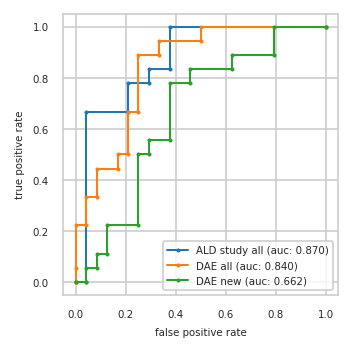

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.667   0.000 0.222   0.042 0.056
3          0.208 0.667   0.042 0.222   0.083 0.056
4          0.208 0.778   0.042 0.333   0.083 0.111
5          0.292 0.778   0.083 0.333   0.125 0.111
6          0.292 0.833   0.083 0.444   0.125 0.222
7          0.375 0.833   0.167 0.444   0.250 0.222
8          0.375 1.000   0.167 0.500   0.250 0.500
9          1.000 1.000   0.208 0.500   0.292 0.500
10           NaN   NaN   0.208 0.667   0.292 0.556
11           NaN   NaN   0.250 0.667   0.375 0.556
12           NaN   NaN   0.250 0.889   0.375 0.778
13           NaN   NaN   0.333 0.889   0.458 0.778
14           NaN   NaN   0.333 0.944   0.458 0.833
15           NaN   NaN   0.500 0.944   0.625 0.833
16           NaN   NaN   0.500 1.000   0.625 0.889
17           NaN   NaN   1.000 1.000   0.792 0.889
18           NaN   NaN     NaN   NaN   0.792 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,G3V4U0;G3XA98;Q9UBX5,O75071,H0Y7T8;P49418;P49418-2
2,A0A0B4J1V0,Q9NZ08;Q9NZ08-2,Q9NUQ9
3,P61981,P02741,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,Q99983,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P14174,P04075,Q8TEA8
7,Q9Y2T3;Q9Y2T3-3,P14174,P31150
8,P08294,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3,Q9NZU1


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


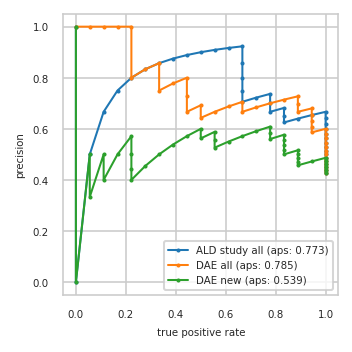

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.630 0.944     0.556 0.833
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.625 0.833     0.667 0.889     0.583 0.778
19         0.652 0.833     0.696 0.889     0.609 0.778
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.706 0.667     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.667 0.556     0.600 0.500
28         0.857 0.667     0.643 0.500     0.571 0.444
29         0.923 0.667     0.692 0.500     0.538 0.389
30         0.917 0.611     0.667 0.444     0.500 0.333
31         0.909 0.556     0.727 0.444     0.455 0.278
32         0.900 0.500     0.800 0.444     0.400 0.222
33         0.889 0.444     0.778 0.389     0.444 0.222
34         0.875 0.389     0.750 0.333     0.500 0.222
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


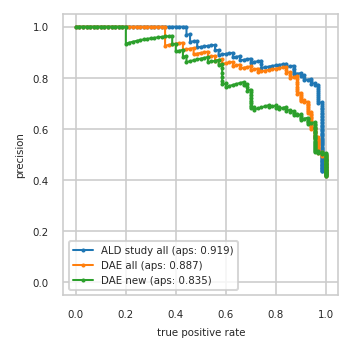

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


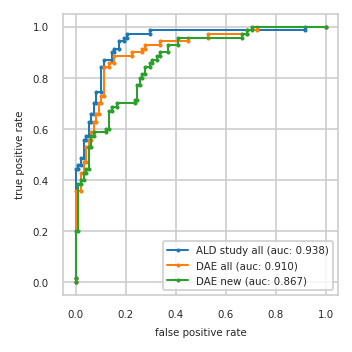

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}